**Objective:**
This notebook serves as a crucial validation step for our `GWASScanner`. The purpose of a negative control test is to ensure that our analysis pipeline does not generate false positives. We will run the fast scan on a genomic region that is known to have no association with insecticide resistance.

**Workflow:**
1.  **Configuration:** Define the insecticide and specify a "gene desert" or a region with no known resistance genes as our negative control.
2.  **Run Scan:** Execute the `GWASScanner` on this specific region.
3.  **Visualize & Interpret:** Plot the results as a Manhattan plot. The expected outcome is a "flat" plot with no statistically significant signals.

A successful negative control gives us much greater confidence that the signals we find in known resistance hotspots (like *Vgsc*) are true biological signals and not artifacts of our statistical method.

### 1. Setup & Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append(os.path.abspath("../src"))

from malariagen_data import Ag3
from analysis.gwas.scanner import GWASScanner
from utils.gwas_utils import parse_regions 

warnings.filterwarnings('ignore', category=UserWarning)

### 2. Configuration for the Negative Control Test

In [2]:
# The insecticide remains the same as our phenotype data is consistent
INSECTICIDE = 'Deltamethrin'

# --- KEY CHANGE: Define the Negative Control Region ---
# We are selecting a 2 Mbp region on the 3R chromosome arm. This region is
# known to be largely intergenic and is not associated with major insecticide
# resistance QTLs, making it an ideal "gene desert" for this test.

NEGATIVE_CONTROL_REGION = '3R:20000000-22000000'

print(f"--- Running Negative Control Test ---")
print(f"Insecticide: {INSECTICIDE}")
print(f"Region: {NEGATIVE_CONTROL_REGION}")

--- Running Negative Control Test ---
Insecticide: Deltamethrin
Region: 3R:20000000-22000000


### 3. Initialize and Run the Scanner

In [3]:
ag3 = Ag3()
scanner = GWASScanner(ag3)

# Run the scan specifically on our negative control region
gwas_results_df_neg = scanner.run_scan(
    insecticide=INSECTICIDE,
    region=NEGATIVE_CONTROL_REGION,
    chunk_size=500_000
)
output_filename = f'../data/gwas_scan_{INSECTICIDE}_NEGATIVE_CONTROL.csv'

Loading and preparing phenotypes for Deltamethrin...
Found 548 samples with valid phenotype data.

--- Processing region 3R:20000000-22000000 ---
Scanning chunk: 3R:20000000-20499999...
Scanning chunk: 3R:20500000-20999999...
Scanning chunk: 3R:21000000-21499999...
Scanning chunk: 3R:21500000-21999999...
Scanning chunk: 3R:22000000-22000000...
                                 
--- Scan complete. ---


### 4. Save and Inspect Results

In [4]:
# +
if not gwas_results_df_neg.empty:
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    gwas_results_df_neg.to_csv(output_filename, index=False)
    print(f"\nScan results saved to {output_filename}")
    
    # In a negative control, we don't expect highly significant SNPs,
    # but we can still look at the "top" hits to see how low their significance is.
    print("\nTop 10 most significant SNPs from the negative control scan (expected to be non-significant):\n")
    display(gwas_results_df_neg.sort_values(by='p_value').head(10))
else:
    print("\nScan completed. As expected, no results were generated, or the region was empty.")


Scan results saved to ../data/gwas_scan_Deltamethrin_NEGATIVE_CONTROL.csv

Top 10 most significant SNPs from the negative control scan (expected to be non-significant):



,contig,pos,p_value,-log10(p)
626990,3R,21387363,2.522758e-07,6.598124
485789,3R,21072543,3.302090e-07,6.481211
405288,3R,20912536,1.087331e-06,5.963638
647598,3R,21430549,1.203679e-06,5.919489
341307,3R,20753194,2.104053e-06,5.676943
283773,3R,20628170,2.123240e-06,5.673001
485646,3R,21072272,2.180962e-06,5.661352
147993,3R,20328462,2.771585e-06,5.557272
378916,3R,20850176,2.940821e-06,5.531531
405272,3R,20912509,3.052759e-06,5.515307


### 5. Visualize the Manhattan Plot

Original points: 902,752
Points to plot after downsampling: 62,186


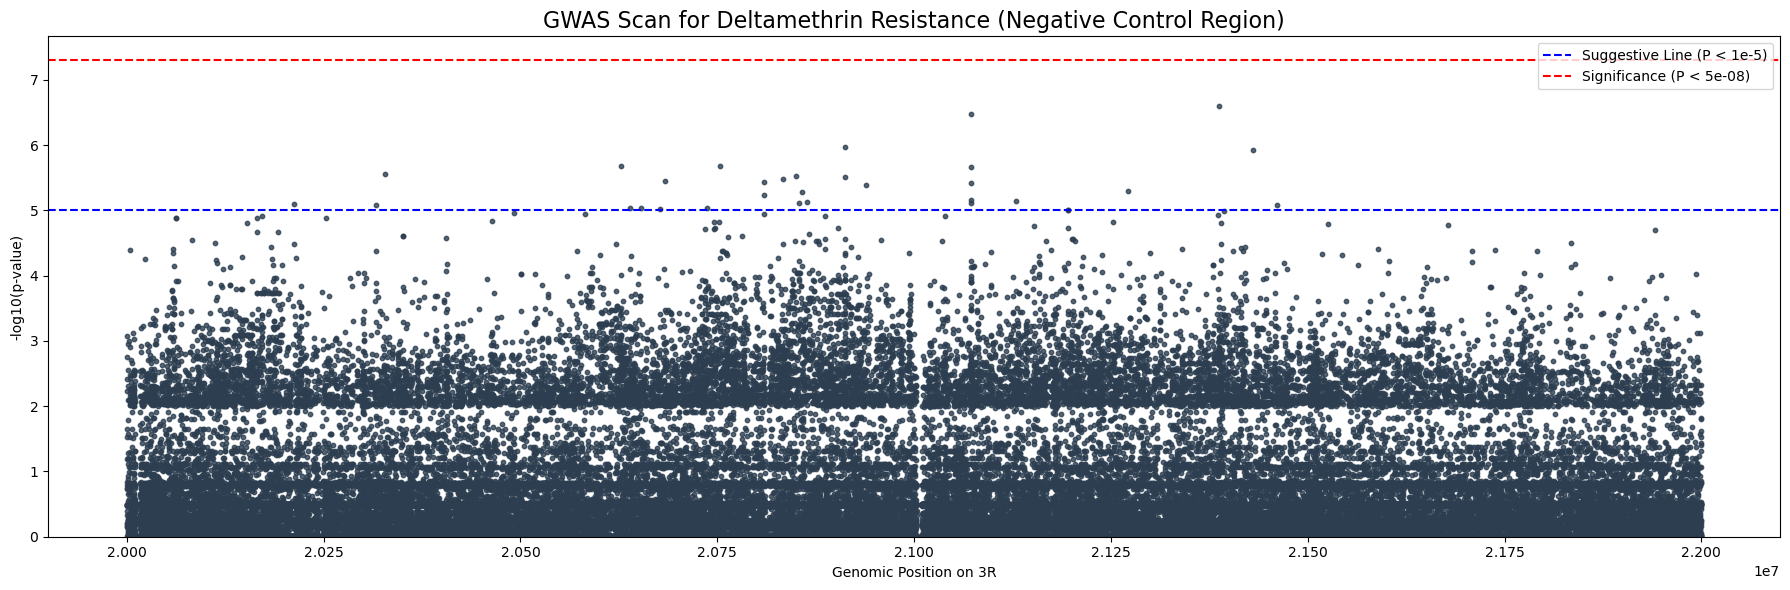

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_manhattan(df, title, ag3, significance_threshold=5e-8, downsample_threshold=2.0):
    """
    Creates a memory-efficient Manhattan plot from GWAS scan results by
    downsampling non-significant points.
    """
    if df.empty:
        print("Results DataFrame is empty. Cannot generate plot.")
        return
    df = df.copy()


    # 1. Identify significant points that we MUST keep
    significant_hits = df[df['-log10(p)'] >= downsample_threshold]
    
    # 2. Identify non-significant points that we can downsample
    non_significant_hits = df[df['-log10(p)'] < downsample_threshold]
    
    # 3. Downsample the non-significant points
    # We will only plot a fraction of them to represent the "noise floor".
    # This is the key to performance.
    n_non_significant_to_plot = 50000 # Plot at most 50,000 background points
    if len(non_significant_hits) > n_non_significant_to_plot:
        non_significant_subset = non_significant_hits.sample(n=n_non_significant_to_plot, random_state=42)
    else:
        non_significant_subset = non_significant_hits
    
    # 4. Combine the two sets into our final DataFrame for plotting
    df_for_plotting = pd.concat([significant_hits, non_significant_subset], ignore_index=True)
    
    print(f"Original points: {len(df):,}")
    print(f"Points to plot after downsampling: {len(df_for_plotting):,}")


    # Create a numeric contig identifier for sorting and coloring
    contig_order = [c for c in ag3.contigs if c in df_for_plotting['contig'].unique()]
    df_for_plotting['contig_cat'] = pd.Categorical(df_for_plotting['contig'], categories=contig_order, ordered=True)
    
    # For a single region plot, we can just use the genomic position directly
    plt.figure(figsize=(18, 6))
    
    # Since it's one region, we don't need alternating colors
    plt.scatter(df_for_plotting['pos'], df_for_plotting['-log10(p)'], color='#2c3e50', s=10, alpha=0.8)
    
    # A common threshold for suggestive significance is around -log10(p) = 5
    plt.axhline(-np.log10(1e-5), color='blue', linestyle='--', lw=1.5, label='Suggestive Line (P < 1e-5)')
    plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--', lw=1.5, label=f'Significance (P < 5e-08)')
    
    plt.xlabel(f'Genomic Position on {df_for_plotting["contig"].iloc[0]}')
    plt.ylabel('-log10(p-value)')
    plt.title(title, fontsize=16)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create a specific title for this validation plot
plot_title = f'GWAS Scan for {INSECTICIDE} Resistance (Negative Control Region)'

plot_manhattan(gwas_results_df_neg, title=plot_title, ag3=ag3)

### Interpretation of the Negative Control Test

**Objective:**
This analysis was performed to validate the `GWASScanner` by running it on a genomic region on chromosome `3R` where no direct insecticide resistance genes were expected. The goal was to check for potential false positives.

**Observations:**

The scan of this negative control region produced a notable peak of association, with the most significant SNP reaching a `-log1-0(p)` value of approximately 6.6. This signal is statistically significant and stronger than what was observed at the known *Vgsc* resistance gene.

**Preliminary Conclusion:**

The presence of a strong signal in a region expected to be negative is an important finding. It strongly suggests that **confounding due to population structure is a significant factor in our dataset.**

A simple Chi-squared test, like the one used in our fast scan, does not account for the genetic differences between mosquito populations from different geographic locations. Therefore, it is possible that the signal detected here is a spurious association, where the SNPs are acting as markers for population ancestry rather than having a direct biological effect on resistance.

**Implications for the Project:**

This result highlights the limitations of an uncorrected GWAS scan for this dataset. It underscores the importance of our planned two-step analysis. The findings from this initial scan should be considered a list of *candidate* signals, which must be further investigated. The next phase of the project, **Phase 2: Verification**, will use more sophisticated statistical models to control for population structure and help differentiate between these potentially spurious associations and true resistance loci.